### A Max Cut Problem

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import networkx as nx
import numpy as np
from qiskit_optimization.applications import Maxcut
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# from qiskit.primitives import StatevectorEstimator, StatevectorSampler

# estimator = StatevectorEstimator()

In [3]:
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')

estimator = BackendEstimator(backend=backend, options={'shots': 1000})

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_3*x_5 - 2*x_4*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



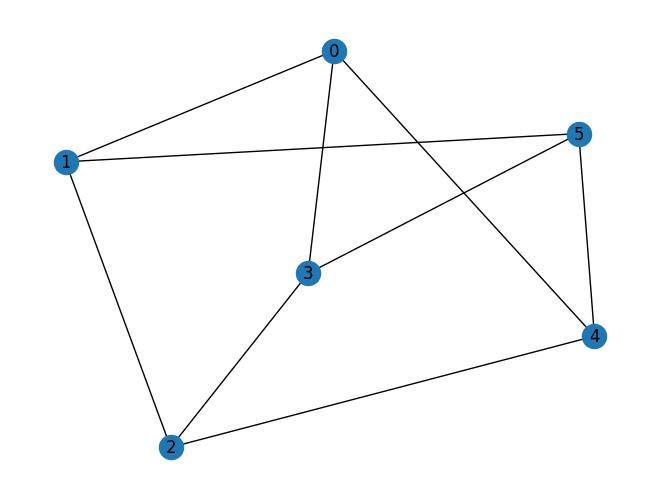

In [4]:
seed = 1
num_nodes = 6
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))
# Assign random weights to the edges

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [5]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Minimize
 obj: - 3 x_0 - 3 x_1 - 3 x_2 - 3 x_3 - 3 x_4 - 3 x_5 + [ 4 x_0*x_1 + 4 x_0*x_3
      + 4 x_0*x_4 + 4 x_1*x_2 + 4 x_1*x_5 + 4 x_2*x_3 + 4 x_2*x_4 + 4 x_3*x_5
      + 4 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [6]:
weight_matrix = np.zeros((num_nodes, num_nodes))

# Assign weight 1 to the edges
for (u, v) in graph.edges():
    weight_matrix[u][v] = 1
    weight_matrix[v][u] = 1  # Since the graph is undirected

# Print the weight matrix
print("Weight matrix:")
print(weight_matrix)

Weight matrix:
[[0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0.]]


### Encoding

In [7]:
from pce import *

In [8]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (2 for quadratic or 3 for cubic and so on)
num_qubits = pauli_encoder.find_n(problem.get_num_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits, problem.get_num_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")


We can encode the problem with 3 qubits using 6 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXI', 'XIX', 'IXX', 'YYI', 'YIY', 'IYY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### The Quantum Ansatz

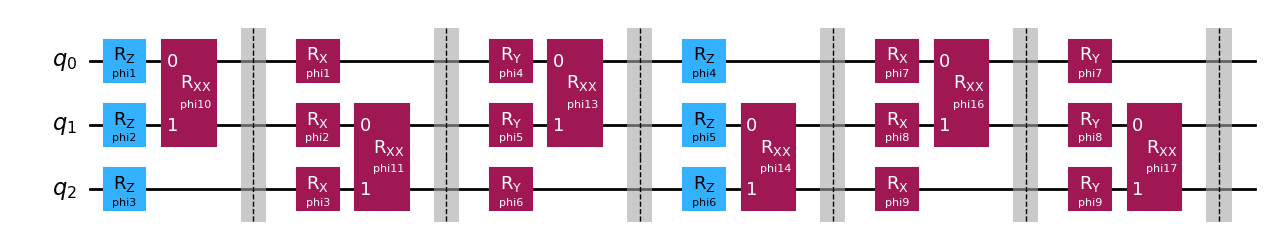

In [9]:
depth = 3
num_nodes = graph.number_of_nodes()
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl')

In [10]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                qp = problem,
                                graph=graph,
                                num_qubits=num_qubits,
                                k=k,
                                max_cut_graph=weight_matrix,
                                method='exact', 
                                loss_method='maxcut',
                                multi_op=False)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut

In [11]:
from qiskit_algorithms.optimizers import COBYLA,SLSQP
optimizer = COBYLA()
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)
print(result)

Single Optimization
[ 0.25791267 -0.62359503  1.67967606  1.16969944  1.25674147  0.63988411
  0.35012442  0.13411309  0.84208161  1.42237245  1.75821532 -0.20507923
  0.28832098  0.51883764  0.81672005]


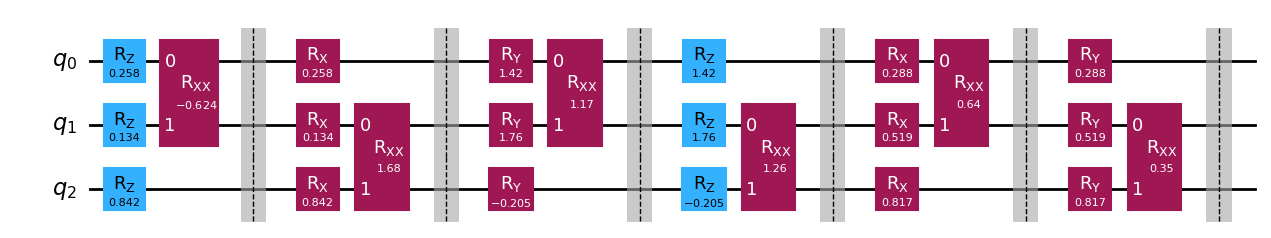

In [12]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl')

In [13]:
psi_final = Statevector(final_ansatz)
print(psi_final)

Statevector([-0.25899983-0.1258811j , -0.05042045-0.59833615j,
             -0.08677054-0.20155415j,  0.10266507+0.06700559j,
             -0.06223348+0.30104095j, -0.2146155 +0.02049729j,
             -0.55482207-0.16354519j, -0.01258853-0.13277786j],
            dims=(2, 2, 2))


In [14]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
max_cut_utility = MaxCutUtility(weight_matrix)
initial_score, max_cut_solution_pce = max_cut_utility.evaluate_initial_score(psi_final, pauli_strings)

print("Initial max-cut score             :", initial_score)
print("Initial max-cut solution          :", max_cut_solution_pce)

Initial max-cut score             : 9.0
Initial max-cut solution          : [1, 0, 1, 0, 0, 1]


### Exact Solution

In [15]:
from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_optimization.algorithms import MinimumEigenOptimizer

exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(problem)
print(exact_result.prettyprint())

objective function value: 9.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=1.0, x_5=0.0
status: SUCCESS
